# Packages

Top cell needed for installing umap in Colab

In [1]:
# !pip install umap-learn[plot]
# !pip install holoviews
# !pip install -U ipykernel

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA

import umap

import networkx as nx

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors

from scipy.sparse import csr_matrix

import scanpy as sc

# Data

In [3]:
# Data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE52529 (FPKM data)
df = pd.read_csv('/home/ubuntu/Datasets/eigenscores/Trapnell.csv', index_col=0)
print(df.shape)
df.head()

(372, 47192)


,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSGR0000234622,ENSGR0000234958,ENSGR0000236017,ENSGR0000236871,ENSGR0000237040,ENSGR0000237531,ENSGR0000237801,ENSGR0000248421,ENSGR0000249358,ENSGR0000270726
T0_CT_A01,21.98440,0.0,40.05970,0.937081,0.740922,0.0,3.00298,128.1970,7.61972,13.024900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T0_CT_A02,7.11663,0.0,55.46040,0.637528,1.405490,0.0,3.12951,41.0211,58.01940,0.458768,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T0_CT_A03,1.28004,0.0,77.58080,0.729195,57.578500,0.0,15.30240,16.0867,0.00000,24.777600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T0_CT_A04,19.60210,0.0,77.34500,12.407500,11.751600,0.0,0.00000,34.3955,0.00000,18.987700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T0_CT_A05,43.46180,0.0,6.49656,0.000000,3.935870,0.0,50.80480,25.3209,0.00000,0.681409,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
adata = sc.AnnData(df)
adata

/tmp/ipykernel_4101/2749062354.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df)


AnnData object with n_obs × n_vars = 372 × 47192

## Preprocessing
Delete cells with less than 200 expressed genes and genes with less than 3 expressed cells.

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 372 × 22288
    obs: 'n_genes'
    var: 'n_cells'

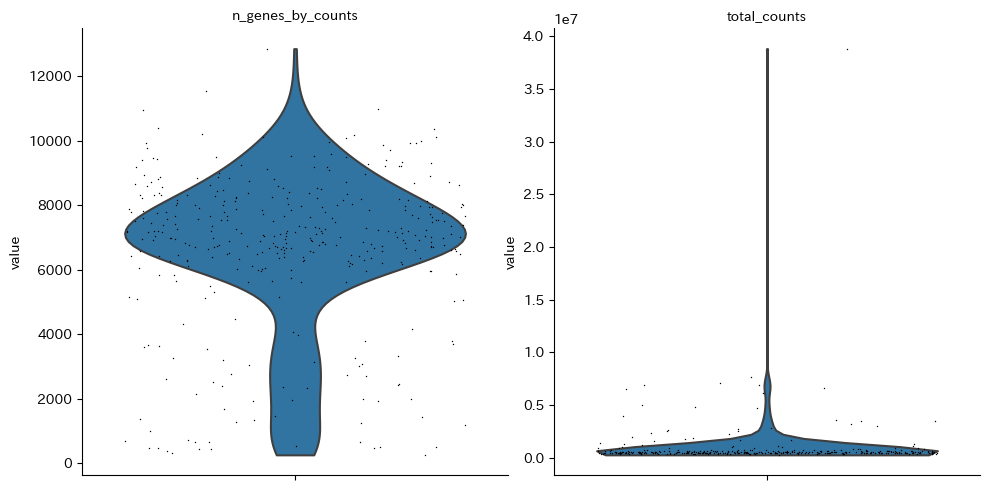

In [6]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],jitter=0.4, multi_panel=True)

Determine thresholds from violin plots:  
Number of expressed genes < 12000

In [7]:
adata = adata[adata.obs.n_genes_by_counts < 12000, :]
adata

View of AnnData object with n_obs × n_vars = 371 × 22288
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Size scaling → Log scaling

In [8]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata, base=2)

/home/ubuntu/.local/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Extract 10000 highly variable genes.

/home/ubuntu/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


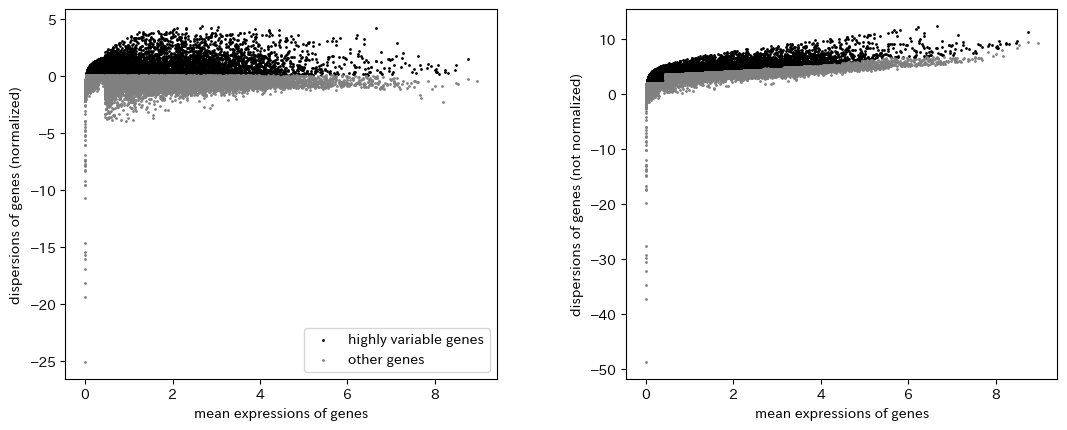

View of AnnData object with n_obs × n_vars = 371 × 10000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [9]:
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=10000)
sc.pl.highly_variable_genes(adata)
adata_10000 = adata[:, adata.var.highly_variable]
adata_10000

In [10]:
data = adata.to_df()

- Apply PCA and restrict to top 30 dimensions.
- For constructing a weighted graph on cells we use a 5-nearest neighbour graph with edge weights between 0 and 1 as given by the fuzzy simplicial set computed by UMAP.
- 'Adj' is the weighted adjacency matrix that will be used for the analysis.

In [11]:
data_np = data.to_numpy()
pca = PCA(30)
pca_data = pca.fit_transform(data_np)
reducer = umap.UMAP(metric="cosine", random_state=44, n_neighbors=5, min_dist=0.3)
emb_data = reducer.fit_transform(pca_data)

fuzzy_ss = umap.umap_.fuzzy_simplicial_set(pca_data, metric="cosine", random_state=44, \
                                           n_neighbors=5)
Adj=csr_matrix.toarray(fuzzy_ss[0])

# Definitions and computation

371


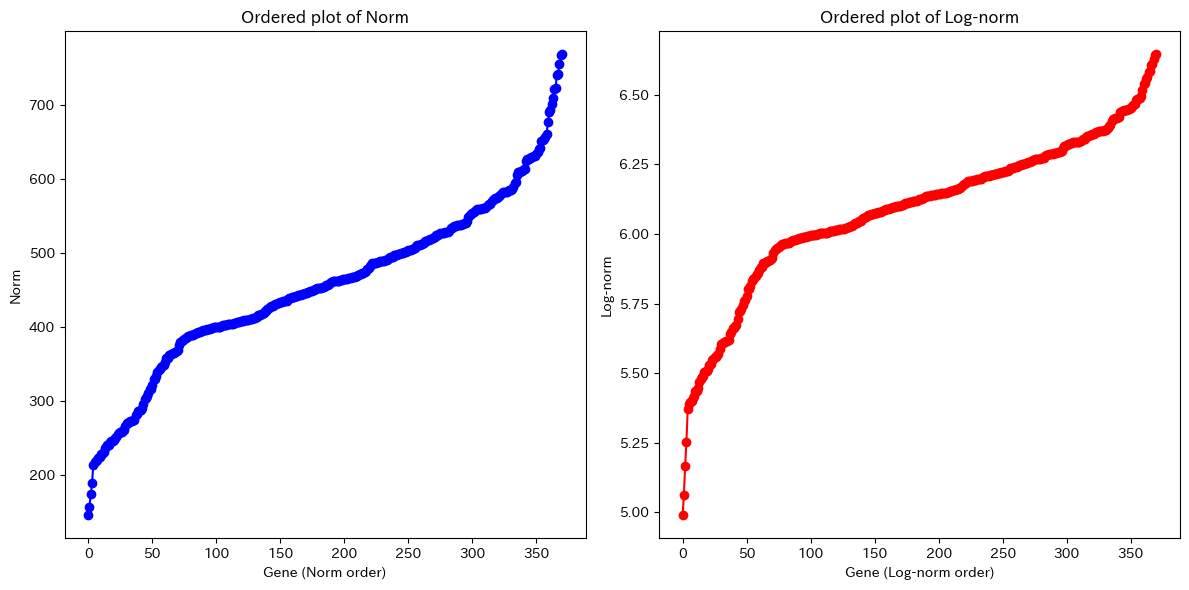

In [12]:
def norm_lapl(adjacency, metric='euclidean'):
    """
    Creates a normalised Laplacian matrix given adjacency matrix.
    """
    degrees = adjacency.sum(axis=0)
    degree_matrix_inv_sqrt = np.diag(degrees ** -0.5)
    norm_lapl = np.eye(adjacency.shape[0]) - degree_matrix_inv_sqrt @ adjacency @ degree_matrix_inv_sqrt # n*n
    return norm_lapl

L = norm_lapl(Adj)
evalues, evectors = np.linalg.eigh(L)

degrees = Adj.sum(axis=0)
degree_matrix_sqrt = np.diag(degrees ** 0.5)

Df = degree_matrix_sqrt @ data
norms = np.linalg.norm(Df, axis=1).reshape((-1,1))

# Calculate log_norm
log_norms = np.log(norms + 1)

# Sort
sorted_indices = np.argsort(log_norms[:, 0])
sorted_norms = norms[sorted_indices]
sorted_log_norms = log_norms[sorted_indices]

print(len(norms))

# Plot norm and log-norm
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(sorted_norms, marker='o', linestyle='-', color='b')
plt.xlabel('Gene (Norm order)')
plt.ylabel('Norm')
plt.title('Ordered plot of Norm')

plt.subplot(1, 2, 2)
plt.plot(sorted_log_norms, marker='o', linestyle='-', color='r')
plt.xlabel('Gene (Log-norm order)')
plt.ylabel('Log-norm')
plt.title('Ordered plot of Log-norm')

plt.tight_layout()
plt.show()

In [13]:
norms = log_norms

normed_genes = Df/norms

components = normed_genes.T @ evectors
compnp = components.to_numpy()
gene_names = components.index

comp_argsort = np.argsort(compnp, axis=0)
scores = np.sort(compnp, axis=0)[::-1, :]

In [14]:
# gene_names を numpy 配列に変換
gene_names_np = np.array(gene_names)

# 以降のコードで numpy 配列を使用
e_scores_pos = gene_names_np[comp_argsort[::-1, :]]
e_scores_neg = gene_names_np[comp_argsort[:, :]]

eigenscore_genes = pd.DataFrame({'$eig_0^+$' : e_scores_pos[0:10,0],
                               '$eig_0^-$ ' : e_scores_neg[0:10,0],
                                 '$eig_1^+$' : e_scores_pos[0:10,1],
                               '$eig_1^-$ ' : e_scores_neg[0:10,1],
                                 '$eig_2^+$' : e_scores_pos[0:10,2],
                               '$eig_2^-$ ' : e_scores_neg[0:10,2],
                                 '$eig_3^+$' : e_scores_pos[0:10,3],
                               '$eig_3^-$ ' : e_scores_neg[0:10,3],
                                 '$eig_4^+$' : e_scores_pos[0:10,4],
                               '$eig_4^-$ ' : e_scores_neg[0:10,4],
                                 '$eig_5^+$' : e_scores_pos[0:10,5],
                               '$eig_5^-$ ' : e_scores_neg[0:10,5]})

In [15]:
eigenscore_genes

,$eig_0^+$,$eig_0^-$,$eig_1^+$,$eig_1^-$,$eig_2^+$,$eig_2^-$,$eig_3^+$,$eig_3^-$,$eig_4^+$,$eig_4^-$,$eig_5^+$,$eig_5^-$
0,ENSG00000211683,ENSG00000198712,ENSG00000249784,ENSG00000166582,ENSG00000154277,ENSG00000135390,ENSG00000100526,ENSG00000107796,ENSG00000159251,ENSG00000133110,ENSG00000008394,ENSG00000159251
1,ENSG00000240510,ENSG00000182718,ENSG00000119705,ENSG00000230673,ENSG00000105640,ENSG00000239672,ENSG00000260549,ENSG00000121769,ENSG00000130600,ENSG00000008394,ENSG00000260549,ENSG00000138435
2,ENSG00000257069,ENSG00000198804,ENSG00000112695,ENSG00000105640,ENSG00000013275,ENSG00000265681,ENSG00000125148,ENSG00000198336,ENSG00000138435,ENSG00000162496,ENSG00000049323,ENSG00000118194
3,ENSG00000257152,ENSG00000034510,ENSG00000125743,ENSG00000268362,ENSG00000147475,ENSG00000087302,ENSG00000157456,ENSG00000159173,ENSG00000081189,ENSG00000049323,ENSG00000125148,ENSG00000008517
4,ENSG00000268397,ENSG00000198938,ENSG00000129235,ENSG00000259727,ENSG00000197756,ENSG00000077549,ENSG00000137804,ENSG00000162496,ENSG00000118194,ENSG00000167815,ENSG00000167815,ENSG00000169271
5,ENSG00000256010,ENSG00000228253,ENSG00000176340,ENSG00000118194,ENSG00000089220,ENSG00000134809,ENSG00000164611,ENSG00000180209,ENSG00000159173,ENSG00000141753,ENSG00000140092,ENSG00000197614
6,ENSG00000120088,ENSG00000229117,ENSG00000063177,ENSG00000089220,ENSG00000034510,ENSG00000222041,ENSG00000203760,ENSG00000185585,ENSG00000148677,ENSG00000152377,ENSG00000152377,ENSG00000180730
7,ENSG00000254633,ENSG00000198899,ENSG00000164405,ENSG00000263327,ENSG00000167862,ENSG00000100603,ENSG00000106366,ENSG00000186594,ENSG00000180730,ENSG00000106333,ENSG00000133110,ENSG00000198336
8,ENSG00000260280,ENSG00000075624,ENSG00000154518,ENSG00000248721,ENSG00000103490,ENSG00000180398,ENSG00000169715,ENSG00000196154,ENSG00000133055,ENSG00000163931,ENSG00000124766,ENSG00000149294
9,ENSG00000188219,ENSG00000231500,ENSG00000146425,ENSG00000228624,ENSG00000033050,ENSG00000111229,ENSG00000166451,ENSG00000176046,ENSG00000165917,ENSG00000102265,ENSG00000099250,ENSG00000159173


Below we check how many eigenscores to take into account by setting the cut-off in eigenvalues to 0.1

In [16]:
sum(evalues < 0.1)

17

We restrict to a 4-dimensional eigenscore space below, which was the number given by the cut-off in the case of the PBMC data set.

In [17]:
comp4 = components.iloc[:, 1:4]
comp4_np = comp4.to_numpy()
distancematrix = squareform(pdist(comp4_np))


reducer = umap.UMAP(metric="precomputed", random_state=12, n_neighbors=5, min_dist=0.1)
emb = reducer.fit_transform(distancematrix)

genes = components.index
emb_df = pd.DataFrame(emb, index = genes)

def annotate_genes2(gene_list, coordinates, ax, x_index, y_index, x_offset, y_offset):
    for gene in gene_list:
        x_coord, y_coord = coordinates.loc[gene][[x_index, y_index]]
        ax.annotate(
            gene,
            xy=(x_coord, y_coord),
            xytext=(x_offset, y_offset),
            textcoords='offset points'
        )

def annotate_genes_dot(gene_list, coordinates, ax, x_index, y_index):
    for gene in gene_list:
        x_coord, y_coord = coordinates.loc[gene][[x_index, y_index]]
        ax.scatter(x_coord, y_coord, s=70, facecolors='none', edgecolors='k')

/home/ubuntu/.local/lib/python3.10/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


In [18]:
comp4

,1,2,3
ENSG00000000003,3.539718,-2.642633,-2.427473
ENSG00000000419,4.651322,-2.997397,0.809495
ENSG00000000457,0.323117,-0.274468,0.259018
ENSG00000000460,0.787569,-0.495543,1.856616
ENSG00000000971,3.613389,-1.758832,-1.363899
...,...,...,...
ENSG00000271631,-1.295636,-0.638041,0.059576
ENSG00000271643,0.252944,-0.192498,0.147936
ENSG00000271646,0.105349,-0.067387,-0.126853
ENSG00000271670,0.456809,-0.261547,-0.527451


# Example output

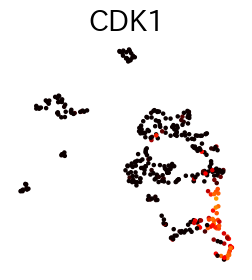

In [19]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('hot')
new_cmap = truncate_colormap(cmap, 0, 0.6)

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(1,1,1)
ax.set_title('CDK1', fontsize = 20)
ax.scatter(emb_data[:,0],emb_data[:,1], s=5, cmap=new_cmap, c=data['ENSG00000170312'])
_ = ax.axis('off')

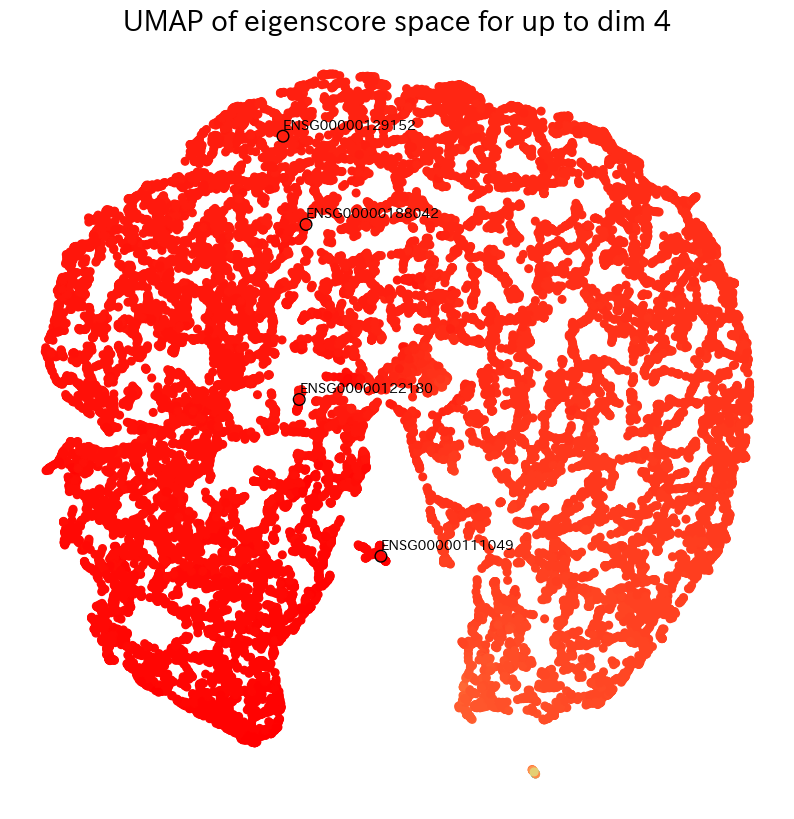

In [20]:
gene_list = ['ENSG00000129152', 'ENSG00000111049', 'ENSG00000122180', 'ENSG00000188042']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_title('UMAP of eigenscore space for up to dim 4', fontsize = 20)
ax.scatter(emb[:,0],emb[:,1], s=30, cmap='rainbow', c=np.log(np.linalg.norm(compnp[:,1:4], axis=1)))
_ = ax.axis('off')
annotate_genes2(gene_list, emb_df, ax, 0, 1, 0, 5)
annotate_genes_dot(gene_list, emb_df, ax, 0, 1)
#plt.savefig('PBMC_umap_eigenscores1-16.svg')